In [1]:
!pip install columnize

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from IPython.display import display               # For displaying outputs in the notebook
import matplotlib.pyplot as plt                   #for interactive plots and simple cases of programmatic plot generation
%matplotlib inline                                
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        #provides access to some variables used or maintained by the interpreter
import os                                         # For manipulating filepath names
import time                                       #provides various time-related functions
import warnings                                   #allows you to handle all warnings with the standard logging
import io                                         #interface to access files and streams
warnings.filterwarnings(action = 'ignore')        #warnings filter controls whether warnings are ignored, displayed
from sklearn.model_selection import train_test_split #Quick utility to split data into train and test set
import gensim                                     #topic modelling library for Python that provides access to Word2Vec
import columnize                                  #format a simple (i.e. not nested) list into aligned columns.
from gensim.models import Word2Vec                #topic modelling library for Python that provides access to Word2Vec
from sklearn.manifold import TSNE                 #containing T-SNE algorithms used to project high dimensional space into lower dimesional space
from numpy.linalg import inv                      #Compute the dot product of two or more arrays in a single function call
import scipy.stats                                #contains a large number of probability distributions for statistical analysis
import scipy as sp                                #collection of mathematical algorithms
import seaborn as sns                             #data visualization library based on matplotlib
# import mxnet as mx                                #open-source deep learning software framework, used to train, and deploy deep neural networks.

### **Download claims data file**

In [3]:
!wget https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip


--2022-02-21 08:09:11--  https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip
Resolving www.cms.gov (www.cms.gov)... 23.65.227.76, 2600:1407:d800:2ae::28a, 2600:1407:d800:28b::28a
Connecting to www.cms.gov (www.cms.gov)|23.65.227.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8848030 (8.4M) [application/zip]
Saving to: ‘2008_BSA_Inpatient_Claims_PUF.zip’

2008_BSA_Inpatient_ 100%[===================>]   8.44M  36.8MB/s    in 0.2s    

2022-02-21 08:09:12 (36.8 MB/s) - ‘2008_BSA_Inpatient_Claims_PUF.zip’ saved [8848030/8848030]



In [4]:
%%sh
# wget https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF_DUGzip.zip
unzip -o /content/2008_BSA_Inpatient_Claims_PUF.zip

Archive:  /content/2008_BSA_Inpatient_Claims_PUF.zip
  inflating: 2008_BSA_Inpatient_Claims_PUF.csv  


### **Feature Engineering**

In [9]:
# read the ColumnNames csv file to identify meaningful names for column labels in the claim data
colnames = pd.read_csv("/content/drive/MyDrive/data/ColumnNames.csv")
colnames[colnames.columns[-1]] = colnames[colnames.columns[-1]].map(lambda x: x.replace('"','').strip())
display(colnames)

,Column Label,"""Column Name"""
0,IP_CLM_ID,Encrypted PUF ID
1,BENE_SEX_IDENT_CD,Beneficiary gender code
2,BENE_AGE_CAT_CD,Beneficiary Age category code
3,IP_CLM_BASE_DRG_CD,Base DRG code
4,IP_CLM_ICD9_PRCDR_CD,ICD9 primary procedure code
5,IP_CLM_DAYS_CD,Inpatient days code
6,IP_DRG_QUINT_PMT_AVG,DRG quintile average payment amount
7,IP_DRG_QUINT_PMT_CD,DRG quintile payment amount code


In [10]:
# read claims data file
df_cms_claims_data = pd.read_csv('/content/2008_BSA_Inpatient_Claims_PUF.csv')
df_cms_claims_data.columns = colnames[colnames.columns[-1]].ravel()
pd.set_option('display.max_columns', 500)

# print the shape of the data file
print('Shape:', df_cms_claims_data.shape)

# show the top few rows
display(df_cms_claims_data.head())

# describe the data object
display(df_cms_claims_data.describe())

# check the datatype for each column
display(df_cms_claims_data.dtypes)

# check null value for each column
display(df_cms_claims_data.isnull().mean())


Shape: (588415, 8)


,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
0,IP-000022CE4125DBE7,2,4,3,31.0,4,86240,4
1,IP-0000417F50942D90,2,5,199,NaN,2,3447,2
2,IP-0000865F5457AC0E,1,1,119,54.0,4,34878,5
3,IP-00009789630AF474,2,2,128,NaN,2,3007,2
4,IP-0000C9D229B79D36,2,2,236,70.0,1,3352,2


,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
count,588415.000000,588415.000000,588415.000000,311869.000000,588415.000000,588415.000000,588415.000000
mean,1.561165,3.574610,140.202393,59.683832,2.516377,9312.621422,2.999444
std,0.496245,1.805788,79.686699,29.207527,0.972758,10482.707298,1.414880
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,2.000000,82.000000,38.000000,2.000000,4008.000000,2.000000
50%,2.000000,4.000000,123.000000,54.000000,2.000000,6352.000000,3.000000
75%,2.000000,5.000000,200.000000,86.000000,3.000000,10760.000000,4.000000
max,2.000000,6.000000,311.000000,99.000000,4.000000,329467.000000,5.000000


Encrypted PUF ID                        object
Beneficiary gender code                  int64
Beneficiary Age category code            int64
Base DRG code                            int64
ICD9 primary procedure code            float64
Inpatient days code                      int64
DRG quintile average payment amount      int64
DRG quintile payment amount code         int64
dtype: object

Encrypted PUF ID                       0.000000
Beneficiary gender code                0.000000
Beneficiary Age category code          0.000000
Base DRG code                          0.000000
ICD9 primary procedure code            0.469985
Inpatient days code                    0.000000
DRG quintile average payment amount    0.000000
DRG quintile payment amount code       0.000000
dtype: float64

### **Missing values**

In [11]:
#Fill NaN with -1 for "No Procedure Performed"
procedue_na = -1
df_cms_claims_data['ICD9 primary procedure code'].fillna(procedue_na, inplace = True)

#convert procedure code from float to int64
df_cms_claims_data['ICD9 primary procedure code'] = df_cms_claims_data['ICD9 primary procedure code'].astype(np.int64)


#check count of null values to ensure dataframe is updated
display(df_cms_claims_data.isnull().mean())

Encrypted PUF ID                       0.0
Beneficiary gender code                0.0
Beneficiary Age category code          0.0
Base DRG code                          0.0
ICD9 primary procedure code            0.0
Inpatient days code                    0.0
DRG quintile average payment amount    0.0
DRG quintile payment amount code       0.0
dtype: float64

### **Categorical features**

,bene_sex_ident_cd,Beneficiary gender
0,1,Male
1,2,Female


Text(0, 0.5, 'Percentage claims')

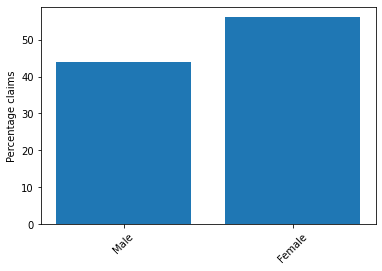

In [12]:
# read gender dictionary csv file
dict_gender = pd.read_csv("/content/drive/MyDrive/data/Gender.csv")
dict_gender.columns = dict_gender.columns.to_series().apply(lambda x: x.strip())
display(dict_gender)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_gender_counts = dict_gender.set_index('bene_sex_ident_cd').join( df_cms_claims_data['Beneficiary gender code'].value_counts() )
tmp_gender_counts['percentage'] = tmp_gender_counts['Beneficiary gender code']/tmp_gender_counts['Beneficiary gender code'].sum()*100

# project gender distribution in the dataset on the bar graph
plt.bar(tmp_gender_counts.index, tmp_gender_counts['percentage'].tolist());
plt.xticks(tmp_gender_counts.index, tmp_gender_counts['Beneficiary gender'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

### Age Group

,BENE_AGE_CAT_CD,Age Group
0,1,Under_65
1,2,65_to_69
2,3,70_to_74
3,4,75_to_79
4,5,80_to_84
5,6,85_and_Older


Text(0, 0.5, 'Percentage claims')

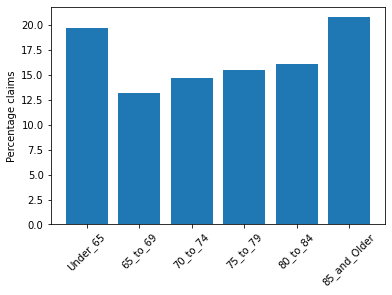

In [13]:
#read AgeGroup csv file into a pandas dataframe
dict_age_group = pd.read_csv("/content/drive/MyDrive/data/AgeGroup.csv", sep=',')
dict_age_group.columns = dict_age_group.columns.to_series().apply(lambda x: x.strip())
display(dict_age_group)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_age_sorted_counts = dict_age_group.set_index('BENE_AGE_CAT_CD').join( df_cms_claims_data['Beneficiary Age category code'].value_counts() )
tmp_age_sorted_counts['percentage'] = tmp_age_sorted_counts['Beneficiary Age category code']/tmp_age_sorted_counts['Beneficiary Age category code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.bar(tmp_age_sorted_counts.index, tmp_age_sorted_counts['percentage'].tolist());
plt.xticks(tmp_age_sorted_counts.index, tmp_age_sorted_counts['Age Group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

### **NLP for Textual features**

#### Diagnosis Descriptions

,Base DRG code,Diagnosis related group
0,1,Heart transplant or implant of heart assist sy...
1,2,"ECMO or trach w MV 96+ hrs or PDX exc face, mo..."
2,3,"Trach w MV 96+ hrs or PDX exc face, mouth & ne..."
3,4,Liver transplant
4,5,Lung transplant


Base DRG code               int64
Diagnosis related group    object
dtype: object

Text(0, 0.5, 'Percentage claims')

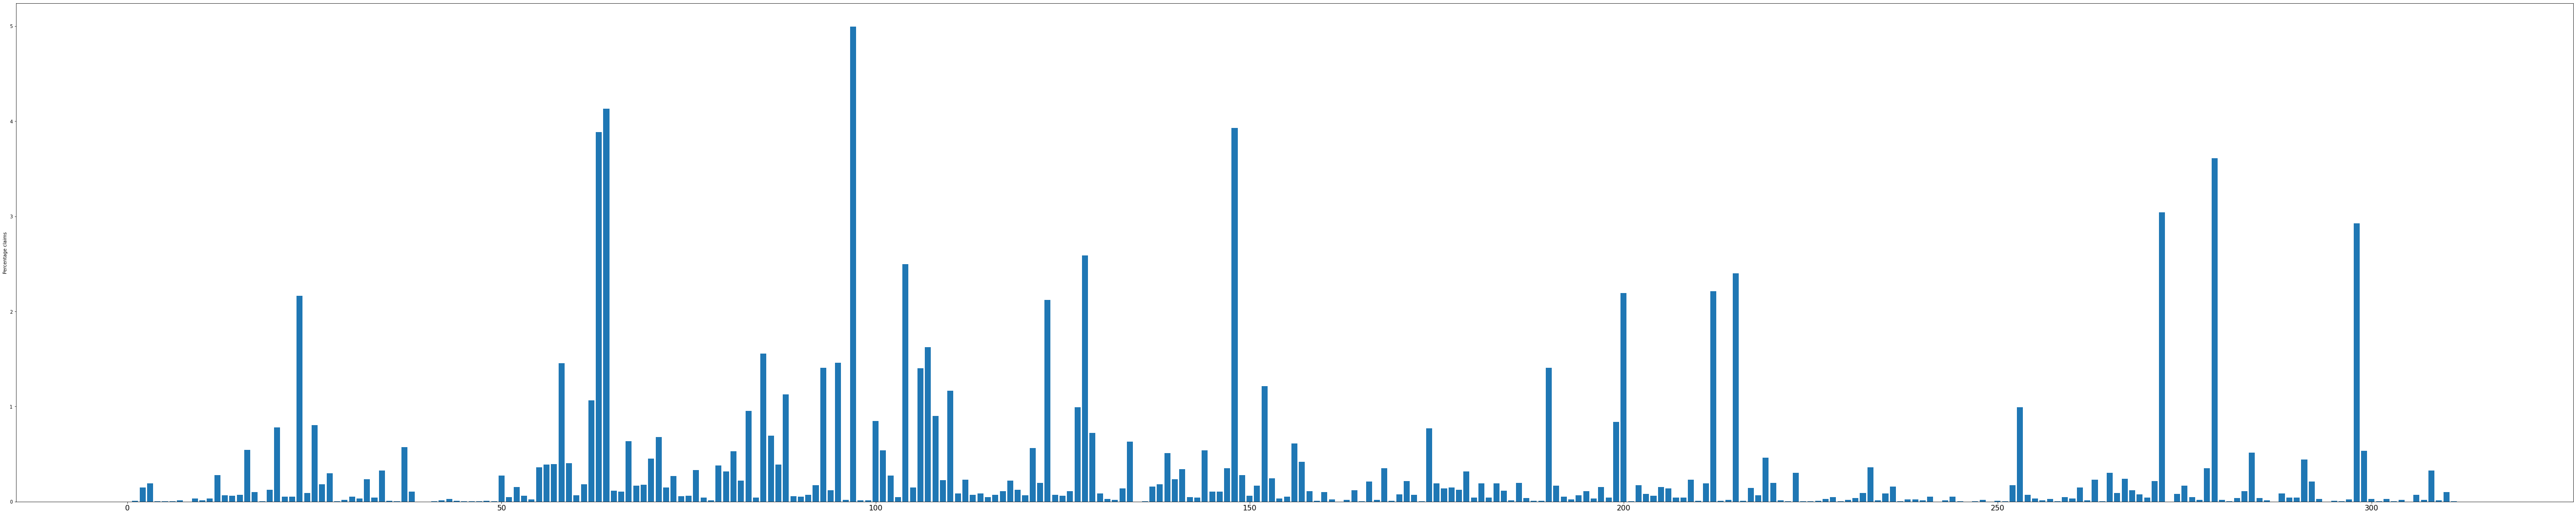

In [14]:
# read the diagnosis names into dataframe, clean up values and display records
dict_diagnosis_names = pd.read_csv('/content/drive/MyDrive/data/DiagnosisRelatedGroupNames.csv', sep=', "', skiprows=1, names=['Base DRG code','Diagnosis related group']);
dict_diagnosis_names['Diagnosis related group'] = dict_diagnosis_names['Diagnosis related group'].map(lambda x: x.replace('"',''));
display(dict_diagnosis_names.head())
display(dict_diagnosis_names.dtypes)


# join the Base DRG code in dictionay with Base DRG code in claims dataframe and describe the distribution amongst different age group in claims dataset
tmp_diagnosis_counts = dict_diagnosis_names.set_index('Base DRG code').join( df_cms_claims_data['Base DRG code'].value_counts() )
tmp_diagnosis_counts['percentage'] = tmp_diagnosis_counts['Base DRG code']/tmp_diagnosis_counts['Base DRG code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.figure(figsize=(100,20))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_diagnosis_counts.index, tmp_diagnosis_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

In [15]:
# function to run pre processing on diagnosis descriptions
from nltk.tokenize import sent_tokenize, word_tokenize 

def text_preprocessing(phrase):
    phrase = phrase.lower()
    phrase = phrase.replace('&', 'and')
    #phrase = phrase.replace('non-', 'non') #This is to ensure non-critical, doesn't get handled as {'non', 'critical'}
    phrase = phrase.replace(',','')
    phrase = phrase.replace('w/o','without').replace(' w ',' with ').replace('/',' ')
    phrase = phrase.replace(' maj ',' major ')
    phrase = phrase.replace(' proc ', ' procedure ')
    phrase = phrase.replace('o.r.', 'operating room')
    sentence = phrase.split(' ')
    return sentence

In [16]:
# run pre processing on diagnosis related group
tmp_diagnosis_tokenized = dict_diagnosis_names['Diagnosis related group'].map(lambda x: text_preprocessing(x))
display(tmp_diagnosis_tokenized.head())

0    [heart, transplant, or, implant, of, heart, as...
1    [ecmo, or, trach, with, mv, 96+, hrs, or, pdx,...
2    [trach, with, mv, 96+, hrs, or, pdx, exc, face...
3                                  [liver, transplant]
4                                   [lung, transplant]
Name: Diagnosis related group, dtype: object

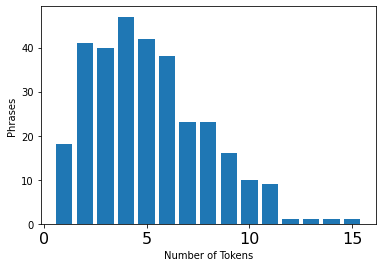

In [17]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
diagnosis_phrase_lengths = tmp_diagnosis_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(diagnosis_phrase_lengths)), diagnosis_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

In [18]:
# traing wordtovec model on diagnosis description tokens
model_drg = Word2Vec(tmp_diagnosis_tokenized, min_count = 1, size = 72, window = 5, iter = 30)
print(model_drg)
diagnosis_words = list(model_drg.wv.vocab)
print(columnize.columnize(diagnosis_words, displaywidth=80, ljust=False))

Word2Vec(vocab=520, size=72, alpha=0.025)
          heart         pulmonary            combined         evisceration
     transplant          embolism            anterior                  rad
             or       respiratory           posterior         hysterectomy
        implant     inflammations              fusion           vulvectomy
             of           pleural                 fus              uterine
         assist          effusion                cerv               adnexa
         system             edema                curv              ovarian
           ecmo           failure               malig              adnexal
          trach           chronic               infec        uterineadnexa
           with       obstructive                  9+          non-ovarian
             mv           disease            cervical       non-malignancy
            96+            simple           bilateral                dandc
            hrs         pneumonia               joint     

In [19]:
# plot TSNE visualization
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

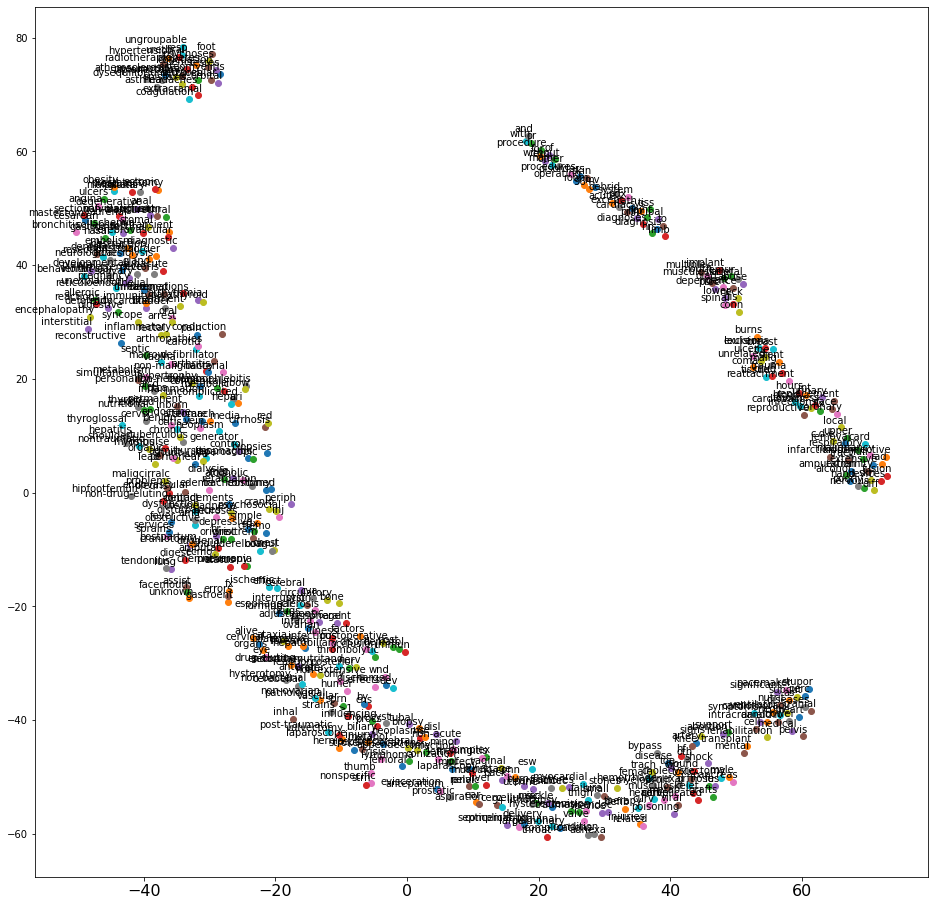

In [20]:
# plot t_SNE chart for diagnosis word to vector. 
#2D visual plot of word embeddings derieved from diagnosis description.
tsne_plot(model_drg)

In [21]:
# test most similiar for some word from model_drg.wv.keywords
model_drg.most_similar('diagnosis')

[('or', 0.997808039188385),
 ('and', 0.9975690841674805),
 ('for', 0.99742192029953),
 ('with', 0.9973189830780029),
 ('operating', 0.9971669316291809),
 ('exc', 0.9971647262573242),
 ('procedures', 0.99709552526474),
 ('procedure', 0.9970878958702087),
 ('major', 0.9969661831855774),
 ('disorders', 0.9969487190246582)]

In [22]:
# extract diagnosis words that starts with non
#display(tmp_diagnosis_tokenized.head())
series_diagnosis = pd.Series(diagnosis_words)
diagnosis_words_with_non = series_diagnosis[series_diagnosis.map(lambda x: 'non' in x)]
display(diagnosis_words_with_non)

76          nonspecific
89         nontraumatic
99        non-bacterial
183    non-drug-eluting
344       non-malignant
370        non-neoplasm
399         non-ovarian
400      non-malignancy
444           non-acute
507       non-extensive
dtype: object

In [23]:
# Check similarity between diagnosis words with opposite severity
for i in diagnosis_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in diagnosis_words:
        print('Cosine similarity between', a, not_a, ':', model_drg.wv.similarity(a, not_a))
        print('')

Cosine similarity between traumatic nontraumatic : 0.9243604

Cosine similarity between bacterial non-bacterial : 0.87619996

Cosine similarity between drug-eluting non-drug-eluting : 0.9226331

Cosine similarity between malignant non-malignant : 0.5332149

Cosine similarity between neoplasm non-neoplasm : 0.81741804

Cosine similarity between ovarian non-ovarian : 0.934433

Cosine similarity between malignancy non-malignancy : 0.8928782

Cosine similarity between acute non-acute : 0.9708972

Cosine similarity between extensive non-extensive : 0.9697653



In [24]:
# calculate mean of word vector in a phrase to derieve phrase vector for diagnosis description
# we plan to use mean of word vectors to derive word embeddings for a phrase
values = []
index =[]
#iterate through list of strings in each diagnosis phrase
for i, v in pd.Series(tmp_diagnosis_tokenized).items():
    #calculate mean of all word embeddings in each diagnosis phrase
    values.append(model_drg[v].mean(axis =0))
    index.append(i)
tmp_diagnosis_phrase_vector = pd.DataFrame({'Base DRG code':index, 'DRG_VECTOR':values})
display(tmp_diagnosis_phrase_vector.head())

,Base DRG code,DRG_VECTOR
0,0,"[0.048770167, -0.10632817, 0.12499579, 0.02069..."
1,1,"[0.07702424, -0.15890358, 0.18162626, 0.033324..."
2,2,"[0.07487978, -0.15308559, 0.17561625, 0.032237..."
3,3,"[0.022923104, -0.040197395, 0.0512537, 0.01125..."
4,4,"[0.016195983, -0.031859923, 0.040755875, 0.009..."


In [25]:
# expand tmp_diagnosis_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
diagnosis_features = tmp_diagnosis_phrase_vector['DRG_VECTOR'].apply(pd.Series)

# rename each variable in diagnosis_features use DRG_F as prefix
diagnosis_features = diagnosis_features.rename(columns = lambda x : 'DRG_F' + str(x + 1))

# view the diagnosis_features dataframe
display(diagnosis_features.head())

,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,0.048770,-0.106328,0.124996,0.020698,-0.162613,-0.096940,-0.075408,0.121289,-0.026319,-0.015718,-0.083885,-0.119407,0.141646,-0.102179,0.010505,0.117416,0.076623,0.122865,-0.045939,0.116961,-0.008015,0.090888,0.009449,-0.012889,-0.041563,-0.007845,0.096265,0.035043,-0.006166,-0.014501,-0.013291,-0.064399,0.005948,0.074161,-0.064168,-0.021958,-0.052579,0.016077,0.076880,-0.092259,-0.030193,-0.063256,0.013420,-0.099699,0.035054,-0.000856,0.095113,-0.023866,0.080558,0.001644,-0.000660,-0.073850,0.075716,-0.045783,-0.037243,-0.037564,0.043559,0.027657,0.015734,0.041970,-0.006422,-0.048910,0.004496,0.074724,-0.032401,0.032530,0.049913,-0.013824,0.082176,0.021286,-0.025699,-0.014070
1,0.077024,-0.158904,0.181626,0.033324,-0.247998,-0.146610,-0.113039,0.181072,-0.038764,-0.024703,-0.126542,-0.179449,0.212911,-0.159937,0.015763,0.177178,0.118120,0.183764,-0.066783,0.176685,-0.007176,0.146971,0.013537,-0.017328,-0.059999,-0.007816,0.147158,0.049764,-0.007239,-0.021952,-0.019677,-0.100746,0.012071,0.112799,-0.095089,-0.037334,-0.079401,0.021482,0.115542,-0.135605,-0.043359,-0.095418,0.017198,-0.155457,0.056091,0.000038,0.143491,-0.040436,0.125403,0.001717,-0.000483,-0.108727,0.115894,-0.071235,-0.054296,-0.056708,0.061677,0.039451,0.023813,0.061531,-0.009726,-0.075047,0.006613,0.113280,-0.044423,0.044774,0.078629,-0.020155,0.125477,0.030197,-0.037068,-0.019356
2,0.074880,-0.153086,0.175616,0.032237,-0.238665,-0.141301,-0.108965,0.175140,-0.037138,-0.023421,-0.122635,-0.173415,0.205182,-0.154300,0.014717,0.170842,0.114544,0.177313,-0.064228,0.171174,-0.007153,0.141653,0.013064,-0.016984,-0.058131,-0.007627,0.141778,0.048609,-0.006984,-0.020395,-0.018396,-0.097371,0.011625,0.108197,-0.091251,-0.035797,-0.076266,0.021334,0.112536,-0.130967,-0.042493,-0.091764,0.016572,-0.150266,0.053822,0.000486,0.137617,-0.038862,0.120279,0.001456,0.000059,-0.103899,0.112028,-0.068979,-0.052594,-0.055339,0.059057,0.037250,0.023327,0.059421,-0.009433,-0.072432,0.006241,0.109458,-0.042708,0.042468,0.075865,-0.019840,0.121611,0.028926,-0.035811,-0.018016
3,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.044980,-0.013170,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.003670,-0.025132,0.002508,0.025187,-0.029899,-0.010316,-0.022914,0.000845,0.026948,-0.033996,-0.015752,-0.024612,0.008781,-0.037570,0.016625,-0.001928,0.037623,-0.008161,0.031138,0.001683,0.001866,-0.027416,0.033271,-0.020043,-0.013232,-0.012556,0.019126,0.015664,0.001328,0.011852,0.000687,-0.023774,0.006658,0.023459,-0.011837,0.015543,0.021520,-0.005150,0.030076,0.010863,-0.006523,-0.010290
4,0.016196,-0.031860,0.040756,0.009926,-0.049023,-0.027286,-0.018077,0.042919,-0.010022,-0.009655,-0.030953,-0.036992,0.041496,-0.032328,0.000697,0.040766,0.030405,0.034933,-0.013111,0.039792,-0.004178,0.029395,0.003781,-0.005626,-0.017354,-0.006372,0.026240,0.011752,-0.006605,-0.004361,-0.008776,-0.016645,0.003010,0.022553,-0.026874,-0.008835,-0.016379,0.005735,0.021477,-0.034463,-0.007270,-0.025380,0.001332,-0.031598,0.009532,0.000027,0.033529,-0.007868,0.028034,-0.000558,-0.000602,-0.017132,0.025355,-0.011326,-0.011015,-0.011455,0.015450,0.012026,0.004263,0.010349,0.001037,-0.018609,0.001536,0.022821,-0.015349,0.014065,0.018047,-0.005843,0.029390,0.005694,-0.010916,-0.00735

#### Procedure Descriptions

In [26]:
#read procedure code and procedure description mappings
dict_procedure_names = pd.read_csv('/content/drive/MyDrive/data/InternationalClassificationOfDiseasesNames.csv', 
                              sep=', "', 
                              skiprows=1, 
                              names=['ICD9 primary procedure code','International Classification of Diseases'])

#replace double quotes with blank
dict_procedure_names = dict_procedure_names.applymap(lambda x: x.replace('"',''))

# replace -1 as code for 'No procedure performed'. In the dictionary the code is set as blank.
dict_procedure_names.iloc[0]['ICD9 primary procedure code'] = procedue_na

# convert procedure code from float to int64
dict_procedure_names['ICD9 primary procedure code'] = dict_procedure_names['ICD9 primary procedure code'].astype(np.int64)


# check the datatype for each column
display(dict_procedure_names.dtypes)

# display first five records in dictionary
display(dict_procedure_names.head())

ICD9 primary procedure code                  int64
International Classification of Diseases    object
dtype: object

,ICD9 primary procedure code,International Classification of Diseases
0,-1,No procedure performed
1,0,Not elsewhere classified
2,1,Incise-excis brain/skull
3,2,Other skull/brain ops
4,3,Spinal cord & canal ops


In [27]:
display(dict_procedure_names.count())

ICD9 primary procedure code                 101
International Classification of Diseases    101
dtype: int64

Text(0, 0.5, 'Percentage claims')

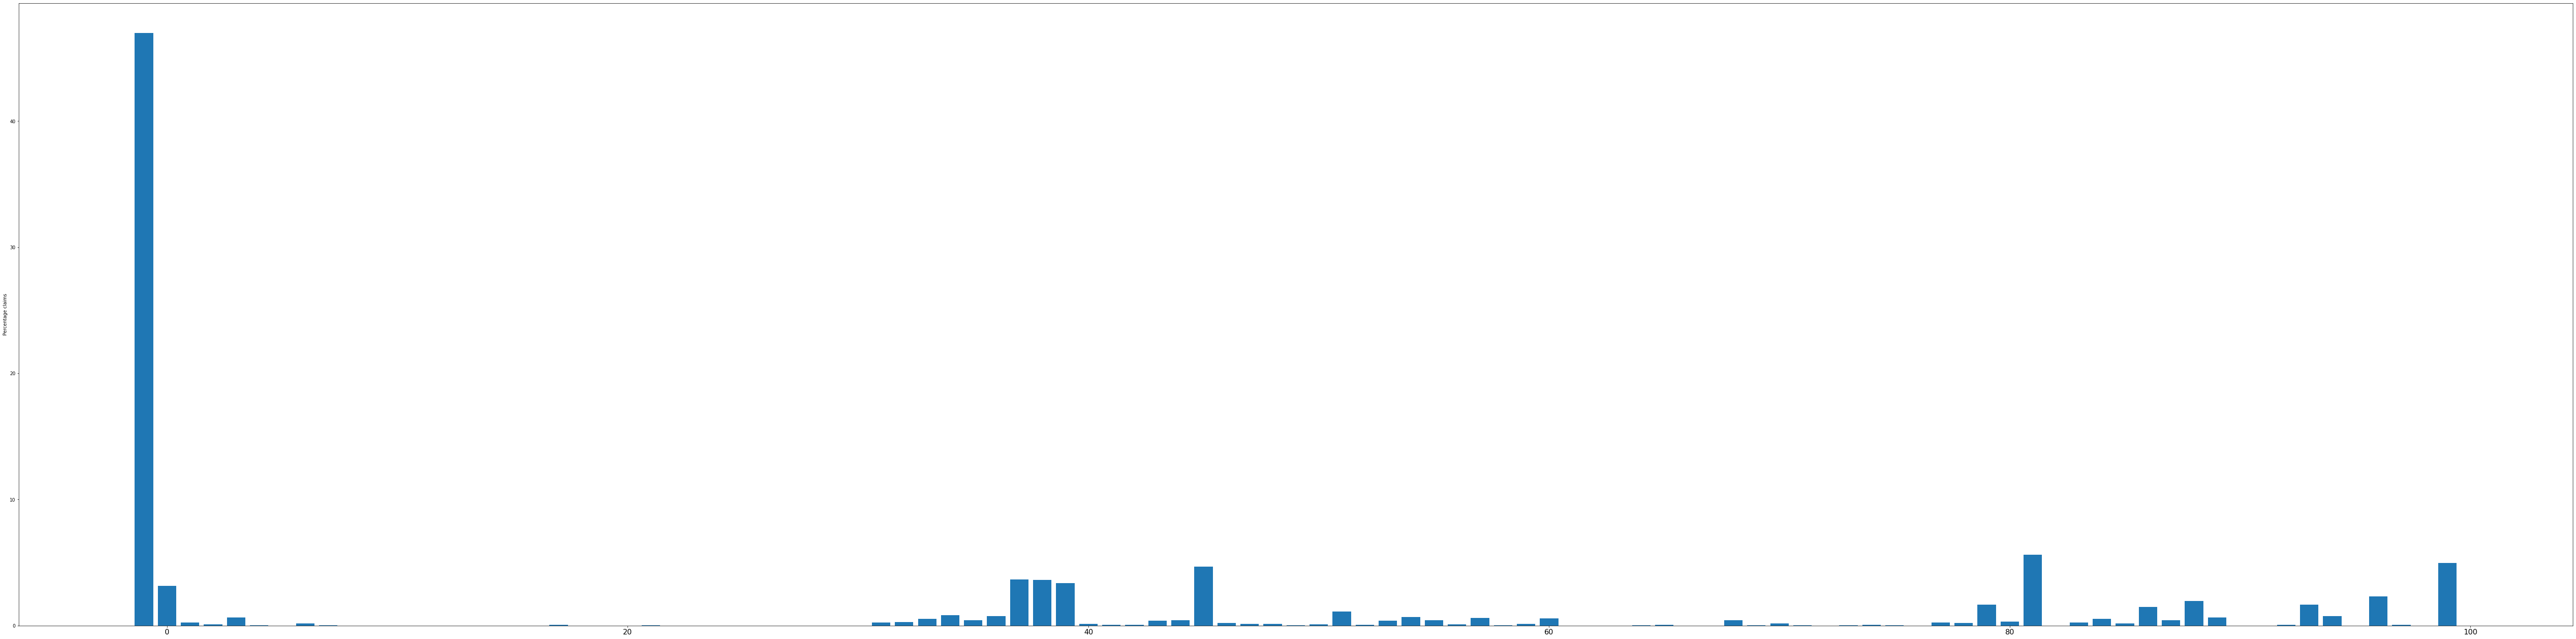

In [28]:
# join the ICD9 primary procedure code in dictionay with ICD9 primary procedure code in claims dataframe and plot the distribution of procedures in the claims dataset
tmp_procedure_counts = dict_procedure_names.set_index('ICD9 primary procedure code').join(df_cms_claims_data['ICD9 primary procedure code'].value_counts() )
tmp_procedure_counts['percentage'] = tmp_procedure_counts['ICD9 primary procedure code']/tmp_procedure_counts['ICD9 primary procedure code'].sum()*100

# project procedure distribution in the claims dataset on the bar graph
plt.figure(figsize=(100,25))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_procedure_counts.index, tmp_procedure_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

In [29]:
# run pre processing on procedure descriptions
tmp_procedure_tokenized = dict_procedure_names['International Classification of Diseases'].map(lambda x: text_preprocessing(x))
display(tmp_procedure_tokenized.head())

0         [no, procedure, performed]
1       [not, elsewhere, classified]
2       [incise-excis, brain, skull]
3         [other, skull, brain, ops]
4    [spinal, cord, and, canal, ops]
Name: International Classification of Diseases, dtype: object

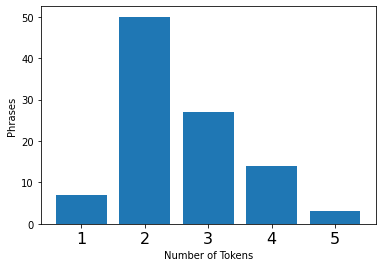

In [30]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
procedure_phrase_lengths = tmp_procedure_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(procedure_phrase_lengths)), procedure_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

In [31]:
# traing wordtovec model on procedure description tokens
model_prc = Word2Vec(tmp_procedure_tokenized, min_count = 1, size = 72, window = 5, iter = 100)
print(model_prc)
procedure_words = list(model_prc.wv.vocab)
print(columnize.columnize(procedure_words, displaywidth=80, ljust=False))

Word2Vec(vocab=193, size=72, alpha=0.025)
          no        segment          of      liver     cul-de-sac    diagnostic
   procedure           lens      larynx    biliary         vulvar     radiology
   performed      posterior     trachea      tract       perineal            dx
         not    extraocular         nec   pancreas         forcep     interview
   elsewhere         muscle        lung     repair            vac       consult
  classified          orbit    bronchus     hernia         breech          exam
incise-excis        eyeball   bronchial    abdomen          deliv   microscopic
       brain  miscellaneous      thorax     region         assist       exam--i
       skull     procedures      except     kidney         induce      exam--ii
       other       external       heart     ureter      c-section       nuclear
         ops            ear      valves    urinary          fetus      medicine
      spinal         middle       septa    bladder      obstetric            p

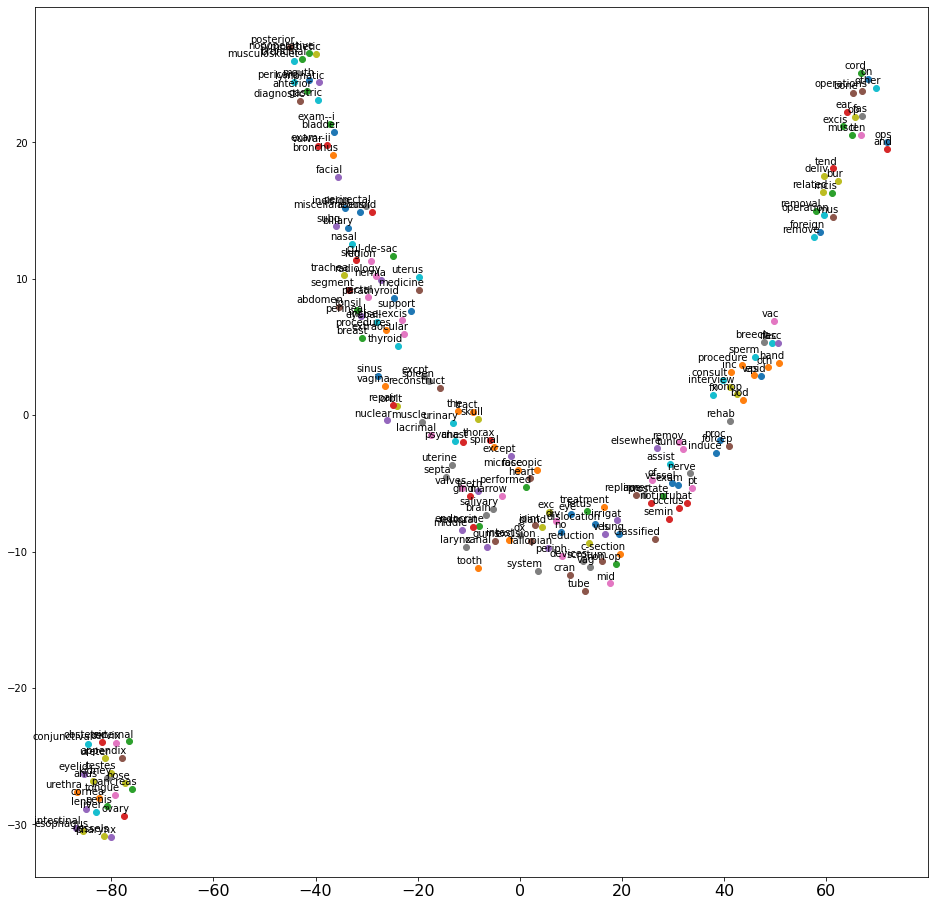

In [32]:
# plot t_SNE chart for procedure word to vector
# #2D visual plot of word embeddings derieved from procedure description.
tsne_plot(model_prc)

In [33]:
# test most similiar for some word from model_prc.wv.keywords
model_prc.most_similar('nonoperative')

[('exam', 0.9357205629348755),
 ('ear', 0.9343116283416748),
 ('remove', 0.934167206287384),
 ('foreign', 0.934023380279541),
 ('nonop', 0.9335657358169556),
 ('skull', 0.9333754777908325),
 ('excis', 0.9321256875991821),
 ('joint', 0.9318293333053589),
 ('ops', 0.9318017363548279),
 ('fallopian', 0.9316288828849792)]

In [34]:
# extract procedure words that starts with non
#display(tmp_procedure_tokenized.head())
series_procedure = pd.Series(procedure_words)
procedure_words_with_non = series_procedure[series_procedure.map(lambda x: 'non' in x)]
display(procedure_words_with_non)

182          non-op
188           nonop
192    nonoperative
dtype: object

In [35]:
# Check similarity between procedure words with opposite severity
for i in procedure_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in procedure_words:
        print('Cosine similarity between', a, not_a, ':', model_prc.wv.similarity(a, not_a))
        print('')

Cosine similarity between op non-op : 0.9891516

Cosine similarity between op nonop : 0.992678



In [36]:
# calculate mean of word vector in a phrase to derieve phrase vector for procedure description 
values = []
index =[]
#iterate through list of strings in each procedure phrase
for i, v in pd.Series(tmp_procedure_tokenized).items():
    #calculate mean of all word embeddings in each procedure phrase
    values.append(model_prc[v].mean(axis =0))
    index.append(i)
tmp_procedure_phrase_vector = pd.DataFrame({'ICD9 primary procedure code':index, 'PRC_VECTOR':values})
display(tmp_procedure_phrase_vector.head())

,ICD9 primary procedure code,PRC_VECTOR
0,0,"[0.025887107, -0.09825498, 0.032416377, -0.013..."
1,1,"[0.025328785, -0.10720209, 0.031655386, -0.015..."
2,2,"[0.024766183, -0.0701117, 0.026437573, -0.0140..."
3,3,"[0.05483485, -0.18602732, 0.06289859, -0.03514..."
4,4,"[0.06139853, -0.22561201, 0.078803435, -0.0425..."


In [37]:
# expand tmp_procedure_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
procedure_features = tmp_procedure_phrase_vector['PRC_VECTOR'].apply(pd.Series)

# rename each variable in procedure_features use PRC_F as prefix
procedure_features = procedure_features.rename(columns = lambda x : 'PRC_F' + str(x + 1))

# view the procedure_features dataframe
display(procedure_features.head())

,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,0.025887,-0.098255,0.032416,-0.013158,-0.039286,-0.051222,0.009627,0.043717,0.040862,0.004677,0.003524,-0.006335,-0.043517,0.007585,0.013010,0.037196,-0.007557,0.016935,-0.016105,-0.017470,0.036757,-0.043484,-0.008901,0.032906,0.047693,-0.004188,-0.004021,-0.021772,-0.003463,0.052852,0.021839,-0.007546,-0.009032,0.014810,0.052158,-0.001074,-0.041248,-0.040247,-0.003665,-0.074009,-0.034364,0.023517,0.014501,0.044347,-0.003613,-0.020882,-0.018489,0.012881,0.018374,0.068718,-0.009131,-0.031313,-0.005686,0.075529,-0.025510,-0.000052,0.021324,0.004391,0.076881,0.037740,0.055699,-0.003376,-0.021302,0.012714,-0.057759,0.064791,-0.020720,0.026083,0.021870,-0.018028,0.022949,0.001764
1,0.025329,-0.107202,0.031655,-0.015920,-0.041537,-0.052331,0.004596,0.049775,0.041359,0.005574,-0.001202,-0.010214,-0.051335,0.016041,0.019364,0.041434,-0.007386,0.017763,-0.011679,-0.020405,0.034051,-0.046500,-0.013453,0.033682,0.044977,-0.012973,-0.008754,-0.028037,0.000955,0.058101,0.025228,-0.004432,-0.001585,0.010902,0.052618,-0.004556,-0.043969,-0.044465,-0.002387,-0.081640,-0.031266,0.021073,0.017492,0.042283,-0.003347,-0.031998,-0.026608,0.014443,0.022990,0.069503,-0.005556,-0.037478,-0.001484,0.073200,-0.025024,-0.001118,0.013718,0.001251,0.084264,0.041278,0.052954,-0.000627,-0.028688,0.015275,-0.057724,0.067621,-0.018552,0.026205,0.014310,-0.022668,0.020645,-0.002352
2,0.024766,-0.070112,0.026438,-0.014080,-0.024010,-0.029526,0.007211,0.030231,0.028928,0.007785,-0.002390,-0.002516,-0.031055,0.009900,0.010480,0.029859,0.001017,0.008864,-0.005896,-0.012843,0.023998,-0.030596,-0.010309,0.027889,0.029872,-0.006361,-0.002162,-0.014651,0.000874,0.032579,0.014906,-0.004635,-0.003836,0.010105,0.036240,-0.001005,-0.031335,-0.026142,-0.005608,-0.058696,-0.019340,0.008958,0.010940,0.031898,-0.002394,-0.019455,-0.013389,0.009231,0.018313,0.052100,-0.003047,-0.024589,-0.000697,0.050559,-0.014176,-0.001832,0.016010,0.007107,0.054025,0.024992,0.036203,-0.000988,-0.019188,0.009482,-0.037426,0.048149,-0.015448,0.020950,0.013324,-0.015087,0.015739,0.000217
3,0.054835,-0.186027,0.062899,-0.035144,-0.076373,-0.089046,0.015136,0.090468,0.073545,0.012528,0.003350,-0.006326,-0.082577,0.022919,0.028391,0.074827,-0.006658,0.027203,-0.021731,-0.033974,0.066875,-0.080279,-0.022330,0.062832,0.081353,-0.023684,-0.007646,-0.046789,-0.001558,0.101033,0.040473,-0.008216,-0.012794,0.020958,0.097836,-0.006838,-0.081969,-0.076642,-0.010920,-0.147594,-0.054540,0.031983,0.026493,0.082117,-0.003853,-0.053144,-0.038130,0.022427,0.044260,0.130131,-0.012592,-0.066501,-0.013429,0.134758,-0.045226,-0.000493,0.036614,0.008066,0.143153,0.069340,0.100082,-0.006281,-0.050224,0.025478,-0.104541,0.125269,-0.035054,0.049723,0.036857,-0.035197,0.043692,-0.000755
4,0.061399,-0.225612,0.078803,-0.042555,-0.091102,-0.109439,0.013857,0.113565,0.086275,0.013304,0.005794,-0.009976,-0.102440,0.028259,0.029448,0.090649,-0.010455,0.030294,-0.028837,-0.044533,0.083869,-0.101577,-0.029262,0.070399,0.099751,-0.027567,-0.016141,-0.058159,-0.005941,0.125760,0.048839,-0.008993,-0.014902,0.024439,0.119803,-0.006911,-0.099939,-0.095083,-0.009108,-0.179747,-0.072289,0.042605,0.033653,0.093855,-0.004917,-0.065933,-0.046243,0.027866,0.058057,0.156545,-0.011383,-0.075818,-0.010506,0.165455,-0.053820,-0.001112,0.042733,0.006843,0.174878,0.091454,0.122101,-0.007058,-0.055607,0.031741,-0.130860,0.151752,-0.045961,0.062570,0.041221,-0.040722,0.053153,-0.000788


In [38]:
#merge diagnosis word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_diagnosis = pd.merge(df_cms_claims_data, diagnosis_features, how='inner', left_on = 'Base DRG code', right_index = True)
display(tmp_join_claim_diagnosis.head())

#merge procedure word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_procedure = pd.merge(tmp_join_claim_diagnosis, procedure_features, how='inner', left_on = 'ICD9 primary procedure code', right_index = True)
display(tmp_join_claim_procedure.head())

#assign new feature set with procedure and diagnosis work embeddings to a new claims feature dataframe
#aggregate all the features extrcated so far to build a final claims feature set for training
claims_features = tmp_join_claim_procedure

,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.04498,-0.01317,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.00367,-0.025132,0.002508,0.025187,-0.029899,-0.010316,-0.022914,0.000845,0.026948,-0.033996,-0.015752,-0.024612,0.008781,-0.03757,0.016625,-0.001928,0.037623,-0.008161,0.031138,0.001683,0.001866,-0.027416,0.033271,-0.020043,-0.013232,-0.012556,0.019126,0.015664,0.001328,0.011852,0.000687,-0.023774,0.006658,0.023459,-0.011837,0.015543,0.02152,-0.00515,0.030076,0.010863,-0.006523,-0.01029
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.04498,-0.01317,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.00367,-0.025132,0.002508,0.025187,-0.029899,-0.010316,-0.022914,0.000845,0.026948,-0.033996,-0.015752,-0.024612,0.008781,-0.03757,0.016625,-0.001928,0.037623,-0.008161,0.031138,0.001683,0.001866,-0.027416,0.033271,-0.020043,-0.013232,-0.012556,0.019126,0.015664,0.001328,0.011852,0.000687,-0.023774,0.006658,0.023459,-0.011837,0.015543,0.02152,-0.00515,0.030076,0.010863,-0.006523,-0.01029
1055,IP-00769E0F26D617F0,1,3,3,31,4,27725,1,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.04498,-0.01317,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.00367,-0.025132,0.002508,0.025187,-0.029899,-0.010316,-0.022914,0.000845,0.026948,-0.033996,-0.015752,-0.024612,0.008781,-0.03757,0.016625,-0.001928,0.037623,-0.008161,0.031138,0.001683,0.001866,-0.027416,0.033271,-0.020043,-0.013232,-0.012556,0.019126,0.015664,0.001328,0.011852,0.000687,-0.023774,0.006658,0.023459,-0.011837,0.015543,0.02152,-0.00515,0.030076,0.010863,-0.006523,-0.01029
1385,IP-009C3541718DECF9,2,4,3,31,4,69162,3,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.04498,-0.01317,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.00367,-0.025132,0.002508,0.025187,-0.029899,-0.010316,-0.022914,0.000845,0.026948,-0.033996,-0.015752,-0.024612,0.008781,-0.03757,0.016625,-0.001928,0.037623,-0.008161,0.031138,0.001683,0.001866,-0.027416,0.033271,-0.020043,-0.013232,-0.012556,0.019126,0.015664,0.001328,0.011852,0.000687,-0.023774,0.006658,0.023459,-0.011837,0.015543,0.02152,-0.00515,0.030076,0.010863,-0.006523,-0.01029
1474,IP-00A71BB8A6B8548E,1,5,3,31,4,86240,4,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.04498,-0.01317,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.00367,-0.025132,0.0

,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.04498,-0.01317,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.00367,-0.025132,0.002508,0.025187,-0.029899,-0.010316,-0.022914,0.000845,0.026948,-0.033996,-0.015752,-0.024612,0.008781,-0.03757,0.016625,-0.001928,0.037623,-0.008161,0.031138,0.001683,0.001866,-0.027416,0.033271,-0.020043,-0.013232,-0.012556,0.019126,0.015664,0.001328,0.011852,0.000687,-0.023774,0.006658,0.023459,-0.011837,0.015543,0.02152,-0.00515,0.030076,0.010863,-0.006523,-0.01029,0.024429,-0.090549,0.031987,-0.016927,-0.036403,-0.042936,0.007656,0.039177,0.035732,0.00304,0.000492,-0.00736,-0.04189,0.015099,0.012866,0.035144,-0.003171,0.014128,-0.018384,-0.017486,0.027515,-0.040213,-0.013826,0.030927,0.04001,-0.011442,-0.007352,-0.023689,0.001144,0.05013,0.015433,-0.001223,-0.00818,0.007718,0.04562,-0.003974,-0.039381,-0.034621,-0.001984,-0.071437,-0.033445,0.01253,0.011955,0.03601,-0.003517,-0.023461,-0.020083,0.008653,0.02014,0.064067,-0.005708,-0.031675,-0.008359,0.06271,-0.024456,-0.000912,0.019231,-0.001613,0.068718,0.037129,0.051265,-0.005979,-0.025656,0.00917,-0.049426,0.057437,-0.011526,0.025667,0.015509,-0.016547,0.01768,0.002464
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,0.022923,-0.040197,0.051254,0.011254,-0.059919,-0.039677,-0.029203,0.04498,-0.01317,-0.010452,-0.034306,-0.044895,0.054067,-0.040599,0.005528,0.050588,0.037541,0.043715,-0.014964,0.050982,-0.006789,0.039273,0.008937,-0.008729,-0.016961,-0.001497,0.032647,0.014463,-0.004994,-0.007891,-0.00367,-0.025132,0.002508,0.025187,-0.029899,-0.010316,-0.022914,0.000845,0.026948,-0.033996,-0.015752,-0.024612,0.008781,-0.03757,0.016625,-0.001928,0.037623,-0.008161,0.031138,0.001683,0.001866,-0.027416,0.033271,-0.020043,-0.013232,-0.012556,0.019126,0.015664,0.001328,0.011852,0.000687,-0.023774,0.006658,0.023459,-0.011837,0.015543,0.02152,-0.00515,0.030076,0.010863,-0.006523,-0.01029,0.024429,-0.090549,0.031987,-0.016927,-0.036403,-0.042936,0.007656,0.039177,0.035732,0.00304,0.000492,-0.00736,-0.04189,0.015099,0.012866,0.035144,-0.003171,0.014128,-0.018384,-0.017486,0.027515,-0.040213,-0.013826,0.030927,0.04001,-0.011442,-0.007352,-0.023689,0.001144,0.05013,0.015433,-0.001223,-0.00818,0.007718,0.04562,-0.003974,-0.039381,-0.034621,-0.001984,-0.071437,-0.033445,0.01253,0.011955,0.03601,-0.003517,-0.023461,-0.020083,0.008653,0.02014,0.064067,-0.005708,-0.031675,-0.008359,0.06271,-0.024456,-0.000912,0.019231,-0.001613,0.068718,0.0

### **Split train and test: train only on normal data**

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

X = claims_features.drop(['Encrypted PUF ID','ICD9 primary procedure code','Base DRG code'], axis=1)
strata = claims_features['DRG quintile payment amount code']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
splits = sss.split(X, strata)
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [40]:
display(X_test.head())
X_test.shape

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
335309,1,5,4,9488,3,0.066542,-0.136367,0.158931,0.028554,-0.211033,-0.124419,-0.098253,0.155440,-0.036237,-0.021125,-0.109207,-0.154061,0.185155,-0.135504,0.014319,0.153337,0.102418,0.158966,-0.059009,0.153304,-0.007935,0.125267,0.015812,-0.013998,-0.052647,-0.005143,0.125612,0.044070,-0.003341,-0.018330,-0.016542,-0.083492,0.010511,0.097060,-0.080581,-0.032218,-0.067227,0.021505,0.100545,-0.115177,-0.038921,-0.083131,0.016767,-0.131643,0.044517,0.001892,0.125161,-0.037922,0.103057,0.002188,0.000366,-0.095589,0.099828,-0.061847,-0.045264,-0.047919,0.055627,0.037309,0.020360,0.055127,-0.009321,-0.064729,0.006235,0.095236,-0.038969,0.038897,0.068850,-0.016002,0.109414,0.026202,-0.031472,-0.019418,0.046497,-0.178028,0.059962,-0.032819,-0.071125,-0.084694,0.010793,0.087329,0.070252,0.011151,0.004491,-0.006316,-0.077324,0.022023,0.026845,0.072157,-0.008203,0.025427,-0.023499,-0.034471,0.064385,-0.079153,-0.020047,0.054744,0.079749,-0.023280,-0.009742,-0.044591,-0.006764,0.099356,0.037540,-0.009648,-0.014382,0.019211,0.094584,-0.006881,-0.075074,-0.074659,-0.009133,-0.138202,-0.052102,0.034174,0.027360,0.076003,-0.002145,-0.049302,-0.035513,0.022590,0.039063,0.122263,-0.015494,-0.061439,-0.013870,0.129801,-0.044613,0.001410,0.033907,0.008307,0.136772,0.069730,0.095185,-0.005919,-0.047287,0.026232,-0.101592,0.120886,-0.035343,0.050408,0.035612,-0.030191,0.041279,-0.000864
13750,2,4,2,5883,1,0.023775,-0.054253,0.067020,0.012127,-0.090179,-0.053970,-0.044016,0.068415,-0.018135,-0.009592,-0.045303,-0.064232,0.078453,-0.060948,0.003672,0.062863,0.041306,0.066265,-0.026310,0.063929,-0.008172,0.048586,0.007980,-0.005856,-0.019172,-0.000640,0.056107,0.013543,-0.004810,-0.012699,-0.011860,-0.034535,0.006909,0.041934,-0.032230,-0.011853,-0.029144,0.005013,0.037260,-0.047247,-0.017577,-0.035195,0.009405,-0.058942,0.021040,-0.002597,0.053277,-0.014961,0.046454,0.000934,-0.002667,-0.040608,0.043993,-0.023632,-0.014653,-0.023686,0.019903,0.016220,0.011141,0.023706,-0.007333,-0.024736,-0.000123,0.040537,-0.014605,0.018454,0.027256,-0.009704,0.044908,0.012107,-0.013076,-0.008247,0.021457,-0.072563,0.022525,-0.011753,-0.029872,-0.037700,0.007224,0.028587,0.028404,0.002324,0.001081,-0.006979,-0.029461,0.008298,0.009563,0.026404,-0.004503,0.013198,-0.008312,-0.011585,0.025909,-0.031411,-0.006763,0.021495,0.028826,-0.008988,-0.002245,-0.019063,0.000121,0.038380,0.015915,-0.000230,-0.007347,0.010349,0.039424,-0.002351,-0.029414,-0.031224,-0.001790,-0.058127,-0.022897,0.013349,0.007104,0.031195,-0.004331,-0.023323,-0.019239,0.005984,0.020878,0.049824,-0.002350,-0.026850,-0.004300,0.051533,-0.017213,-0.000729,0.018373,-0.000620,0.056951,0.032254,0.042319,-0.000990,-0.018428,0.005791,-0.036522,0.045457,

(93561, 149)

### **Standardize data based on training sample**

In [41]:
n_obs, n_features = X_train.shape

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_stndrd_train = scaler.transform(X_train)
X_stndrd_train = pd.DataFrame(X_stndrd_train, index=X_train.index, columns=X_train.columns)
X_stndrd_train.shape

(218308, 149)

### **Anomaly Detection by Auto Encoder**

#### Train a auto encoder model

In [42]:
!pip install pyod            # normal install
!pip install --pre pyod      # pre-release version for new features


     |████████████████████████████████| 114 kB 5.2 MB/s 
  Created wheel for pyod: filename=pyod-0.9.7-py3-none-any.whl size=136279 sha256=07bf7883e786e6781a52fa7cd38decdc79e5c8ddc8955e06356f6a46c67f4e10
  Stored in directory: /root/.cache/pip/wheels/ce/14/ae/60cbb36511e59bc12f8f0883805f586db3b315972b54865d33
Successfully built pyod


In [43]:
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import mean_squared_error as mse
contamination = 0.1 
epochs = 30

# Train a model
auto_estimator = AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=10,                           
                            hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
                            l2_regularizer=0.001,
                             optimizer='adam',
                            output_activation='sigmoid', preprocessing=True, random_state=None,
                            validation_size=0.1, verbose=1)

In [44]:
auto_estimator.fit(X_stndrd_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 149)               22350     
                                                                 
 dropout (Dropout)           (None, 149)               0         
                                                                 
 dense_1 (Dense)             (None, 149)               22350     
                                                                 
 dropout_1 (Dropout)         (None, 149)               0         
                                                                 
 dense_2 (Dense)             (None, 25)                3750      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 5

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=10,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.001,
      loss=<function mean_squared_error at 0x7f873f9bab00>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [45]:
auto_pred = auto_estimator.labels_  
auto_scores = auto_estimator.decision_scores_ 

In [49]:
X_stndrd_train['score']=auto_scores
X_stndrd_train['anomaly']=auto_pred
X_stndrd_train = X_stndrd_train.filter(["anomaly","DRG quintile payment amount code","DRG quintile average payment amount","Inpatient days code","Beneficiary Age category code","Beneficiary gender code"])
X_stndrd_train.head()

,anomaly,DRG quintile payment amount code,DRG quintile average payment amount,Inpatient days code,Beneficiary Age category code,Beneficiary gender code
294047,0,-1.525237,-0.527719,1.358837,-0.261926,-1.091073
57872,1,1.294494,0.410172,-0.627204,1.459495,-1.091073
368219,0,0.589561,-0.384233,-1.620225,-0.835733,0.916529
484283,0,1.294494,-0.154974,0.365817,-1.409540,-1.091073
396314,0,0.589561,-0.030827,-0.627204,-0.835733,-1.091073


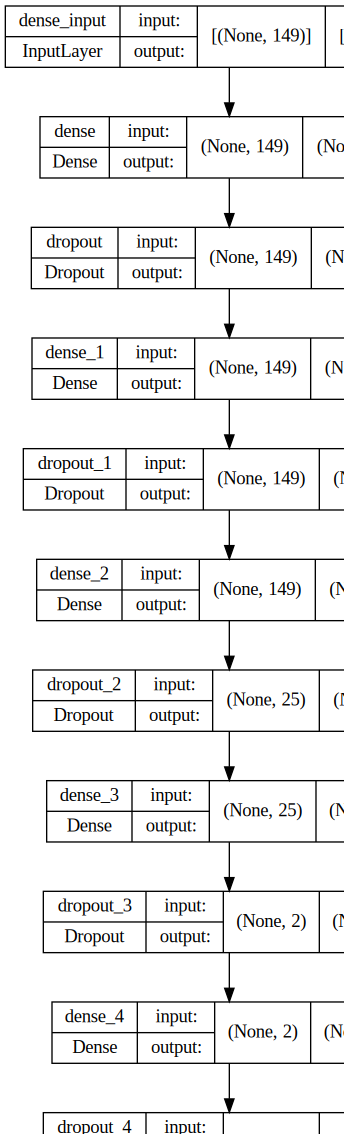

In [53]:
from keras.utils.vis_utils import model_to_dot 
from IPython.display import SVG
SVG(model_to_dot(auto_estimator.model_, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))